Создание модели...
Поиск собственных значений...
Вычисление собственных функций...
Вычисление коэффициентов...


<ipython-input-1-51ac95dbe741>:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  norm = quad(integrand_norm, 0, 1, limit=200)[0]
<ipython-input-1-51ac95dbe741>:120: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  an = quad(integrand_an, 0, 1, limit=200)[0] / norm


Расчет теплового потока...
Визуализация результатов...


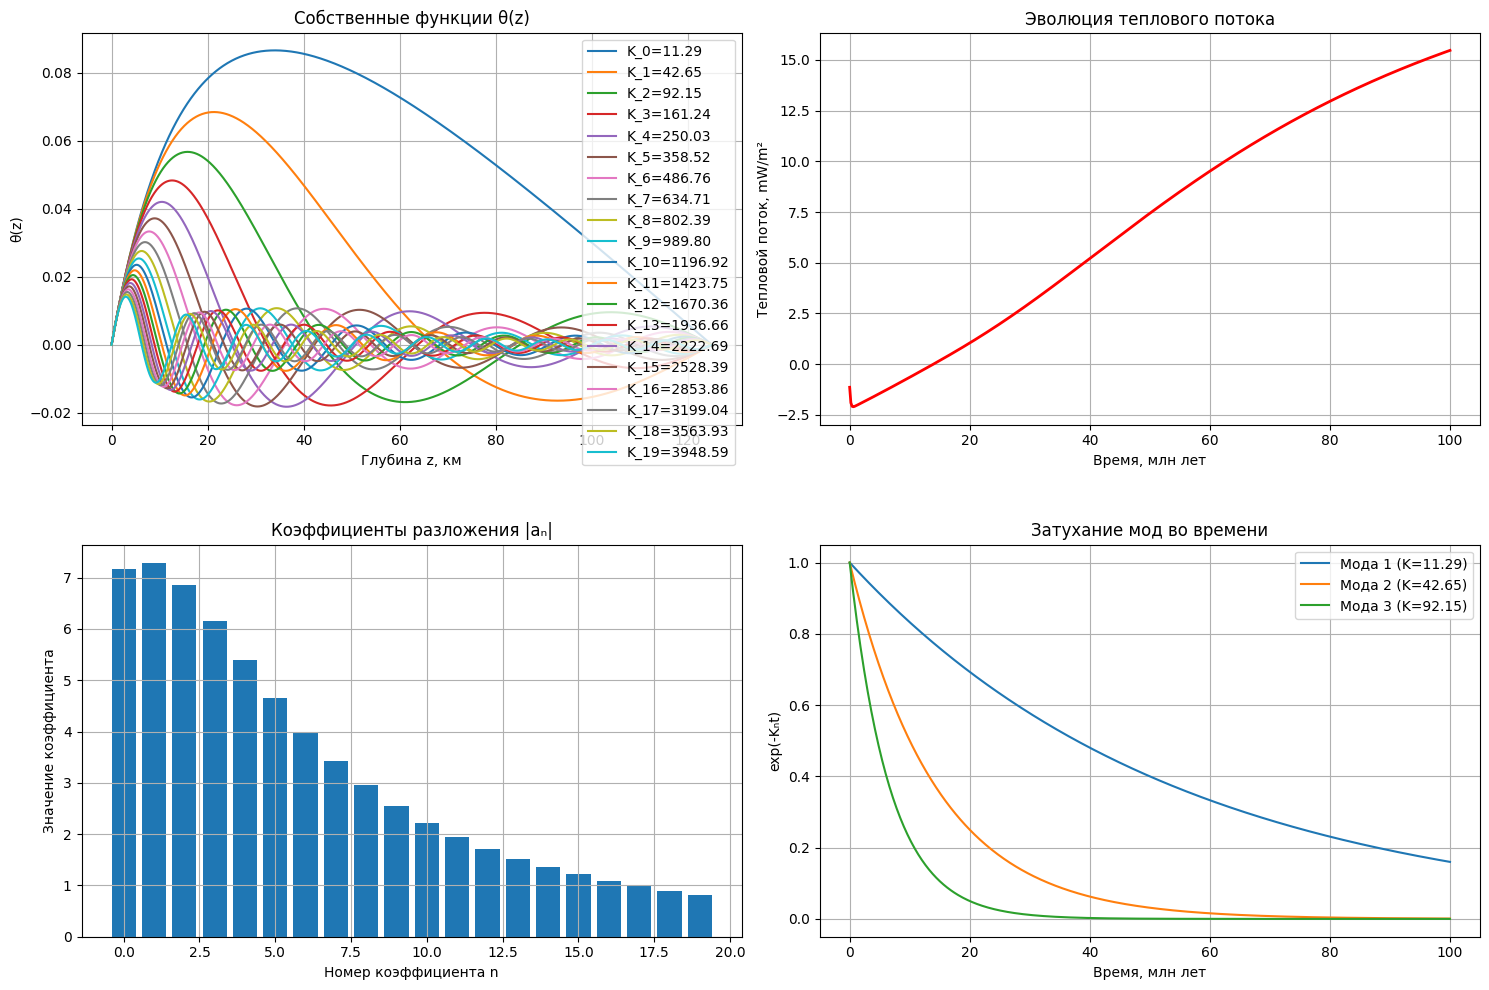


Результаты сохранены в файл thermal_flux_Gprime_10.0.dat
Собственные значения сохранены в eigenvalues_Gprime_10.0.dat


In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
from scipy.special import erf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Физические константы
a = 125e3  # толщина литосферы [м]
k = 3.138  # теплопроводность [W/m/K]
T1 = 1333  # температура границы литосфера-астеносфера [°C]
kappa = 8.04e-7  # температуропроводность [m²/s]

class ThermalModel:
    def __init__(self, G_prime):
        self.G_prime = G_prime
        self.eigenvalues = None
        self.eigenfunctions = None
        self.coefficients = None

    def diff_eq(self, z, y, K):
        """Уравнение Штурма-Лиувилля (A-4)"""
        theta, dtheta = y
        return [dtheta,
                -self.G_prime*(1-z)*dtheta - K*theta]

    def propagator_matrix(self, K):
        """Метод матрицы пропагатора для нахождения собственных значений"""
        sol = solve_ivp(
            fun=lambda z, y: self.diff_eq(z, y, K),
            t_span=(0, 1),
            y0=[0, 1],  # θ(0)=0, θ'(0)=1
            method='RK45',
            dense_output=True
        )
        return sol.sol(1)[0]  # Возвращаем θ(1)

    def find_eigenvalues(self, n_values=20):
        """Нахождение первых n собственных значений"""
        self.eigenvalues = []

        # Функция для поиска корней
        def equation(K):
            return self.propagator_matrix(K)

        # Начальные предположения для корней
        K_guesses = [(n+1)**2 * np.pi**2 + self.G_prime/2 for n in range(n_values)]

        for guess in K_guesses:
            try:
                res = root_scalar(
                    equation,
                    x0=guess,
                    method='newton',
                    fprime=lambda K: (equation(K+1e-6) - equation(K-1e-6))/2e-6,
                    rtol=1e-8
                )
                if res.converged:
                    self.eigenvalues.append(res.root)
            except:
                continue

        self.eigenvalues = sorted(self.eigenvalues)[:n_values]
        return self.eigenvalues

    def compute_eigenfunctions(self, z_points=1000):
        """Вычисление собственных функций"""
        if self.eigenvalues is None:
            self.find_eigenvalues()

        z = np.linspace(0, 1, z_points)
        self.eigenfunctions = []

        for K in self.eigenvalues:
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],
                t_eval=z,
                method='RK45'
            )
            self.eigenfunctions.append(sol.y[0])

        return z, self.eigenfunctions

    def compute_derivatives(self):
        """Вычисление производных собственных функций"""
        self.dtheta_n = []
        z = np.linspace(0, 1, 1000)

        for K, theta in zip(self.eigenvalues, self.eigenfunctions):
            # Решаем систему для θ и θ'
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],  # θ(0)=0, θ'(0)=1
                t_eval=z,
                method='RK45'
            )
            self.dtheta_n.append(sol.y[1])  # Сохраняем производные

    def compute_coefficients(self, initial_condition):
        """Вычисление коэффициентов разложения"""
        if self.eigenfunctions is None:
            self.compute_eigenfunctions()

        self.coefficients = []
        z_points = np.linspace(0, 1, 1000)

        for n, theta_n in enumerate(self.eigenfunctions):
            # Интерполяция собственной функции
            theta_interp = np.interp(z_points, np.linspace(0, 1, len(theta_n)), theta_n)

            # Численное интегрирование для нормировки
            integrand_norm = lambda z: np.exp((z-1)**2 * self.G_prime/2) * np.interp(z, z_points, theta_interp)**2
            norm = quad(integrand_norm, 0, 1, limit=200)[0]

            # Численное интегрирование для коэффициента
            integrand_an = lambda z: initial_condition(z) * np.interp(z, z_points, theta_interp) * np.exp((z-1)**2 * self.G_prime/2)
            an = quad(integrand_an, 0, 1, limit=200)[0] / norm

            self.coefficients.append(an)

        return self.coefficients

    def thermal_flux(self, t):
        """Исправленный расчёт теплового потока"""
        if not hasattr(self, 'dtheta_n'):
            self.compute_derivatives()  # Новый метод для вычисления производных

        t_sec = t * 1e6 * 365.25 * 24 * 3600

        # Стационарный член
        term1 = (k * T1) / a
        term2 = (2/np.pi) * erf(np.sqrt(self.G_prime/2))

        # Временной член
        term3 = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            term3 += an * np.exp(-Kn * kappa * t_sec / a**2) * dtheta[-1]

        return term1 * (term2 + term3) * 1000  # mW/m²

def initial_condition(z):
    """Начальное условие (может быть изменено)"""
    return np.sin(np.pi*z)

# Параметры моделирования
G_prime = 10.0
time_Myr = np.linspace(0, 100, 500)  # 0-100 млн лет

# Создаем и решаем модель
print("Создание модели...")
model = ThermalModel(G_prime)
print("Поиск собственных значений...")
model.find_eigenvalues(n_values=20)
print("Вычисление собственных функций...")
z, eigenfunctions = model.compute_eigenfunctions()
print("Вычисление коэффициентов...")
model.compute_coefficients(initial_condition)
print("Расчет теплового потока...")
flux = [model.thermal_flux(t) for t in time_Myr]

# Визуализация результатов
print("Визуализация результатов...")
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# 1. Собственные функции
ax1 = plt.subplot(gs[0, 0])
for i, (K, theta) in enumerate(zip(model.eigenvalues, eigenfunctions)):
    ax1.plot(z*a/1e3, theta, label=f'K_{i}={K:.2f}')
ax1.set_title('Собственные функции θ(z)')
ax1.set_xlabel('Глубина z, км')
ax1.set_ylabel('θ(z)')
ax1.legend()
ax1.grid()

# 2. Тепловой поток
ax2 = plt.subplot(gs[0, 1])
ax2.plot(time_Myr, flux, 'r-', linewidth=2)
ax2.set_title('Эволюция теплового потока')
ax2.set_xlabel('Время, млн лет')
ax2.set_ylabel('Тепловой поток, mW/m²')
ax2.grid()

# 3. Коэффициенты разложения
ax3 = plt.subplot(gs[1, 0])
ax3.bar(range(len(model.coefficients)), np.abs(model.coefficients))
ax3.set_title('Коэффициенты разложения |aₙ|')
ax3.set_xlabel('Номер коэффициента n')
ax3.set_ylabel('Значение коэффициента')
ax3.grid()

# 4. Первые три моды
ax4 = plt.subplot(gs[1, 1])
for i in range(min(3, len(eigenfunctions))):
    ax4.plot(time_Myr, [np.exp(-model.eigenvalues[i]*kappa*t*1e6*365.25*24*3600/a**2)
                       for t in time_Myr],
            label=f'Мода {i+1} (K={model.eigenvalues[i]:.2f})')
ax4.set_title('Затухание мод во времени')
ax4.set_xlabel('Время, млн лет')
ax4.set_ylabel('exp(-Kₙt)')
ax4.legend()
ax4.grid()

plt.tight_layout()
plt.show()

# Добавляем в конец кода (после визуализации) запись в файл:

# Запись теплового потока в файл
output_filename = f"thermal_flux_Gprime_{G_prime:.1f}.dat"
with open(output_filename, 'w') as f:
    # Заголовок с параметрами
    f.write(f"# Thermal flux output (G'={G_prime:.1f})\n")
    f.write("# Time(Myr) Flux(mW/m2)\n")

    # Запись данных
    for t, q in zip(time_Myr, flux):
        f.write(f"{t:.2f}\t{q:.4f}\n")

print(f"\nРезультаты сохранены в файл {output_filename}")

# Дополнительная запись собственных значений
eigenvalues_filename = f"eigenvalues_Gprime_{G_prime:.1f}.dat"
with open(eigenvalues_filename, 'w') as f:
    f.write("# Eigenvalues and coefficients\n")
    f.write("# n K_n a_n\n")
    for n, (K, a) in enumerate(zip(model.eigenvalues, model.coefficients)):
        f.write(f"{n}\t{K:.6f}\t{a:.6f}\n")

print(f"Собственные значения сохранены в {eigenvalues_filename}")